# PHYS247-HW2
Steven Mills

## a)
read tweet_counts.csv and print the average number of weekly tweet counts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

#csvfile = r'C:\Users\steve\Desktop\Riverside\PHYS247\Introduction-to-applied-data-science\Homework\tweet_counts.csv'
csvfile = r'tweet_counts.csv'
data = np.genfromtxt(csvfile, delimiter=',', skip_header=1, dtype=int)
weeks = data[:,0]
tweet_counts = data[:,1]
tweet_ave = np.mean(tweet_counts)
'%2.2f' % tweet_ave

'38.77'

## b)
print a bar plot of tweet count by week

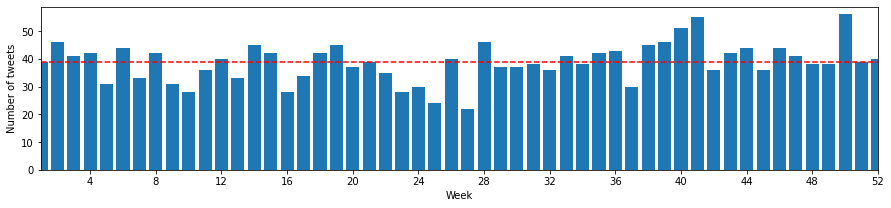

In [2]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.bar(weeks, tweet_counts)
ax.axhline(y=tweet_ave, color='r', linestyle='dashed')
plt.xlim(1, 52)
plt.xticks(np.arange(4, 53, 4))
plt.yticks(np.arange(0, int(math.ceil(np.max(tweet_counts)/10.0)) * 10, 10))
plt.ylabel('Number of tweets')
plt.xlabel('Week')
plt.show()

# c)
Model Prior Belief with an exponential distribution
<div align="center"> $P(λ) = \alpha e^{-\alpha \lambda}$</div>

<div align="left"> Prove explicity that the expected value of $\lambda$ , $E(λ) = 1/\alpha$</div>
<div align="center"> $E(λ) = 1/\alpha$</div>

General formula for expected value is:
<div align="center"> $E(X) = \int_{-\infty}^{\infty} x f_X(x)dx$</div>

In this case
<div align="left"> $E(λ) = \int_{0}^{\infty} {\lambda \alpha e^{-\alpha \lambda} d\lambda}$</div>

integrate by parts
<div align="left"> $\int_{a}^{b} {udv} = uv|_{a}^{b} - \int_{a}^{b} {vdu}$</div>

<div align="left"> let $u = \lambda , du = 1$</div>
<div align="left"> let $dv = e^{-\alpha \lambda} , v = -\frac{1}{\alpha} e^{-\alpha \lambda}$</div>

(detailed steps available upon request)

result of integration is: $\frac{1}{\alpha}$

# d)
take average value from part a), plot estimated distribution $P(\lambda)$ vs. $\lambda$


α = 0.026


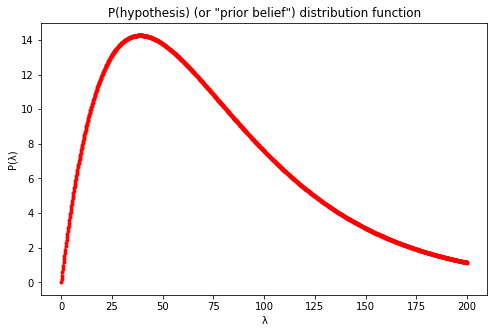

In [3]:
Pexp=lambda λ, α: α*(np.exp(-α*λ))
Pexp=np.vectorize(Pexp)

α = 1/tweet_ave
print('α = %0.3f' % α)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,200, 1000), Pexp((α), np.linspace(0, 200, 1000)), c='r', marker='.')
plt.ylabel('P(λ)')
plt.xlabel('λ')
plt.title('P(hypothesis) (or "prior belief") distribution function')
plt.show()

# e-f)

For this step, I want to follow example of Discussion 3 and use Bayes theorem to calculate Posterior Probabilities.

\begin{equation*}
P(hypothesis|data)\propto P(data|hypothesis) P(hypothesis)
\end{equation*}

<div align="center"> $P(data|hypothesis)(k;\lambda)=\frac{\lambda^k e^{-\lambda}}{k!}$</div>
<div align="center"> $P(hypothesis)(\lambda, \alpha)=\alpha e^{-\alpha \lambda}$</div>

Find posterior of each point in 3-D mesh grid (dimensions of 3-D mesh grid are $\lambda_1$, $\lambda_2$, $W_S$)

Use piecewise likelihood function before and after pivot (change point) w_s

Do not normalize in this step.

In [4]:
poisson = lambda k, _lambda: ((_lambda**k)*np.exp(-_lambda))/np.math.factorial(k)
poisson = np.vectorize(poisson)

exponential = lambda _lambda, alpha: alpha*(_lambda*np.exp(-_lambda*alpha))
exponential = np.vectorize(exponential)

l1_est = np.linspace(25, 50, 50)
l2_est = np.linspace(25, 50, 50)

prior = exponential(l1_est, (1/tweet_ave))

def posterior(l1, l2, ws, data):
    """
    this function was written with help from Nima Chartab
    """
    alpha = 1/tweet_ave
    post = 1
    for d in data[:ws]:
        post *= poisson(d, l1)*alpha*np.exp(-alpha*l1)
    for d in data[ws:]:
        post *= poisson(d, l2)*alpha*np.exp(-alpha*l2)
    return post

ps = []
for l1 in l1_est:
    for l2 in l2_est:
        for w in weeks:
            p = posterior(l1, l2, w, tweet_counts)
            ps.append([l1, l2, w, p])

ps = np.array(ps)  # 130000 x 4 matrix, each row vector represents single point (l1, l2, ws, p)

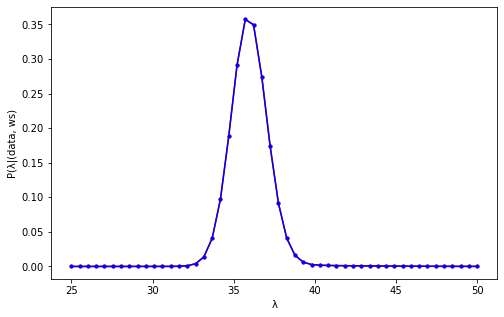

In [5]:
# didn't have time to learn meshgrid due to being lost in wilderness of figuring out Bayes numerator ...
# ps (posteriors) from above loop are stored like:
#     50 l1 * 50 l2 * 52 ws in that order
_ps = ps[:,3] # just the posteriors themselves

#################### lambda 1 ####################
# find the 50 posteriors associated with each value of l1
# sum sequences of 2600 (50*52) and store average value
p_l1 = [(np.sum(_ps[i*2600:(i+1)*2600])) for i in range(50)]
p_l1 = p_l1/np.trapz(p_l1,l1_est)

#################### lambda 2 ####################
# find the 50 posteriors associated with each value of l2
# arrangement in matrix not very user friendly
p_l2 = np.array([])
for i in range(50):
    sum = 0.
    for j in range(50):
        for k in range(52):
            sum += _ps[i*2600 + j*52 + k]
    p_l2 = np.append(p_l2, sum)
p_l2 = p_l2/np.trapz(p_l2,l2_est)

plt.figure(figsize=(8,5))
plt.plot(l1_est, p_l1, c='r', marker='.')
plt.plot(l2_est, p_l2, c='b', marker='.')
plt.ylabel('P(λ|(data, ws)')
plt.xlabel('λ')
plt.show()

### P(lambda|(data, ws)) plot is same for both lambda1 and lambda2

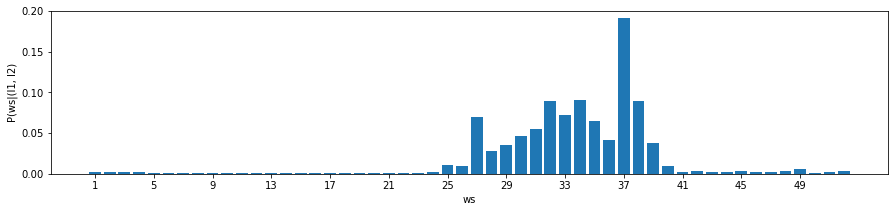

In [6]:
#################### ws ####################
# find the 52 posteriors associated with each value of ws
# there are 2500 of each week in the _ps data
p_ws = np.array([np.sum(_ps[i::52]) for i in range(52)])
p_ws = p_ws/np.trapz(p_ws, weeks)

fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.bar(weeks, p_ws)
plt.ylabel('P(ws|(l1, l2)')
plt.xlabel('ws')
plt.xticks(np.arange(1, 52, 4))
plt.show()

# g) Week 37
Based on the ws bar plot, a change point occured at week 37.
My original guess was closer to week 28, based on optics (tall next to short)

In [7]:
np.argmax(p_ws) + 1

37

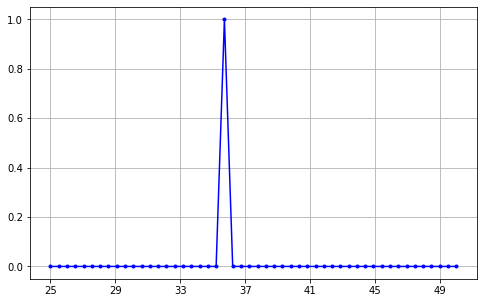

In [8]:
p_delta = p_l2 - p_l1
p_delta = p_delta/np.trapz(p_delta, l1_est)

dd = []
for i in range(50):
    if p_delta[i] > 5.:
        dd.append(1.)
    else:
        dd.append(0.)
        
plt.figure(figsize=(8,5))
#plt.plot(l1_est, p_delta, c='r', marker='.')
plt.plot(l1_est, dd, c='b', marker='.')
plt.xticks(np.arange(25, 52, 4))
plt.grid(True)
plt.show()